# Unet for Lumbar Spine Segmentation

## Data preparation

In [3]:
import os
import hdf5storage
import matplotlib.pyplot as plt
import numpy as np

DEBUG_MODE = True
DATA_PATH='C:/Research/LumbarSpine/OriginalData/RealSegmentationData/'
H, W, D, C, O = 512, 512, 30, 1, 4
BATCH_SIZE = 3
NUM_EPOCHS = 5
LEARNING_RATE = 0.01
LR_SCHEDULER = 30

In [4]:
if DEBUG_MODE:
    MatData=hdf5storage.loadmat(DATA_PATH + 'SegData_P' + str(1)  +'.mat',
                            options=hdf5storage.Options(matlab_compatible=True))
    print (MatData.keys())

dict_keys(['BgSegMap', 'DSegMap', 'I', 'OtherSegMap', 'VSegMap'])


In [5]:
if DEBUG_MODE:
    x_data = MatData['I']
    y0_data, y1_data, y2_data, y3_data = MatData['DSegMap'], MatData['VSegMap'], \
                                     MatData['BgSegMap'], MatData['OtherSegMap']
    print(x_data.shape, type(x_data))
    print(y0_data.shape, y1_data.shape, y2_data.shape, y3_data.shape, type(y0_data))

(512, 512) <class 'numpy.ndarray'>
(512, 512) (512, 512) (512, 512) (512, 512) <class 'numpy.ndarray'>


### Initalize Pytorch Dataloader Class 

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
    
class spineSegDataset(Dataset):
    def __init__(self, path):
        self.input_images = np.zeros((D, C, H, W))
        self.mask_images = np.zeros((D, O, H, W))
        self.__dataload(path)
        
    def __dataload(self, path):
        if not os.path.isdir(path):
            raise FileNotFoundErrore('Path is not a directory')
        
        for i in range(0, D):
            MatData=hdf5storage.loadmat(path + 'SegData_P' + str(i+1)  +'.mat',
                            options=hdf5storage.Options(matlab_compatible=True))
            for j in range(0, C):
                self.input_images[i, j] = MatData['I']
            channels = ('DSegMap', 'VSegMap', 'BgSegMap', 'OtherSegMap')
            for j in range(0, O):
                self.mask_images[i, j] = MatData[channels[j]]
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.mask_images[idx]
        
        return [image, mask]

### Unit Test for Dataloader

This part will test whether dataset is will wrapped together with dataloader.

In [7]:
UnitTrainset = spineSegDataset(path=DATA_PATH)
UnitTrainloader = DataLoader(dataset=UnitTrainset, batch_size=3, shuffle=True)
UnitPlotloader = DataLoader(dataset=UnitTrainset, batch_size=1, shuffle=True)
for image, mask in UnitTrainloader:
    print(type(image), type(mask))
    print(image.shape, mask.shape)
    break

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3, 1, 512, 512]) torch.Size([3, 4, 512, 512])


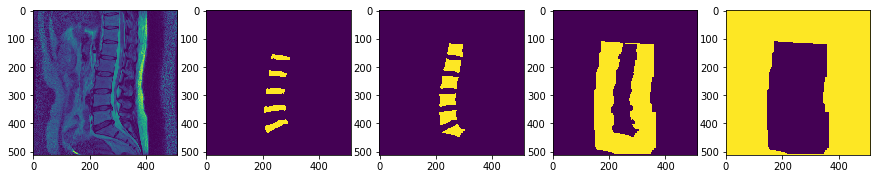

In [8]:
import torchvision.utils
    
for image, mask in UnitTrainloader:
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,15))
    axs[0].imshow(image.numpy()[0, 0], interpolation='none')
    axs[1].imshow(mask.numpy()[0, 0])
    axs[2].imshow(mask.numpy()[0, 1])
    axs[3].imshow(mask.numpy()[0, 2])
    axs[4].imshow(mask.numpy()[0, 3])
    break

## Unet

### Dataset Split

In [9]:
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import torch

torch.manual_seed(17)

spine_dataset = spineSegDataset(path=DATA_PATH)
spine_trainset, spine_validset, spine_testset = random_split(spine_dataset, lengths=[20, 5, 5])
spine_dataset = {
    'train': spine_trainset,
    'valid': spine_validset,
    'test': spine_testset
}
spine_loader = {
    'train': DataLoader(spine_trainset, batch_size=BATCH_SIZE, shuffle=True),
    'valid': DataLoader(spine_validset, batch_size=BATCH_SIZE, shuffle=True),
    'test': DataLoader(spine_validset, batch_size=1, shuffle=True)
}

### Create Unet Model

In [10]:
from collections import OrderedDict

import torch
import torch.nn as nn

#### Parameters Reference for nn.Conv2d(in_channels, out_channels, kernel_size, padding)
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, name, block_batch_norm=True):
        super(UNetBlock, self).__init__()
        self.block_batch_norm = block_batch_norm
        
        self.block = nn.Sequential(OrderedDict([
                        (name + "conv1", nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False)),
                        (name + "norm1", nn.BatchNorm2d(out_ch)),
                        (name + "relu1", nn.ReLU(inplace=True)),
                        (name + "conv2", nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False)),
                        (name + "norm2", nn.BatchNorm2d(out_ch)),
                        (name + "relu2", nn.ReLU(inplace=True))
        ]))
        
        self.block_wo_norm = nn.Sequential(OrderedDict([
                        (name + "conv1_wo", nn.Conv2d(in_ch, out_ch, 3, padding=1)),
                        (name + "relu1_wo", nn.ReLU(inplace=True)),
                        (name + "conv2_wo", nn.Conv2d(out_ch, out_ch, 3, padding=1)),
                        (name + "relu2_wo", nn.ReLU(inplace=True))
        ]))
        
    def forward(self, input):
        if self.block_batch_norm:
            return self.block(input)
        else:
            return self.block_wo_norm(input)
        

class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=4, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNetBlock(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNetBlock(features, features*2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNetBlock(features*2, features*4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNetBlock(features*4, features*8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNetBlock(features*8, features*16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features*16, features*8, kernel_size=2, stride=2
        )
        self.decoder4 = UNetBlock((features*8)*2, features*8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNetBlock((features*4)*2, features*4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNetBlock((features*2)*2, features*2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNetBlock(features*2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

### Model Summary

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
model = model.to(device)

from torchsummary import summary
summary(model, input_size=(1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             288
       BatchNorm2d-2         [-1, 32, 512, 512]              64
              ReLU-3         [-1, 32, 512, 512]               0
            Conv2d-4         [-1, 32, 512, 512]           9,216
       BatchNorm2d-5         [-1, 32, 512, 512]              64
              ReLU-6         [-1, 32, 512, 512]               0
         UNetBlock-7         [-1, 32, 512, 512]               0
         MaxPool2d-8         [-1, 32, 256, 256]               0
            Conv2d-9         [-1, 64, 256, 256]          18,432
      BatchNorm2d-10         [-1, 64, 256, 256]             128
             ReLU-11         [-1, 64, 256, 256]               0
           Conv2d-12         [-1, 64, 256, 256]          36,864
      BatchNorm2d-13         [-1, 64, 256, 256]             128
             ReLU-14         [-1, 64, 2

### Define Loss

In [12]:
import torch.nn as nn


class CalcultedLoss(nn.Module):

    def __init__(self):
        super(CalcultedLoss, self).__init__()
        self.smooth = 1.0
        
    def _dice_loss(self, y_pred, y_true, metrics):
        y_pred = y_pred.contiguous()
        y_true = y_true.contiguous()       
        intersection = (y_pred * y_true).sum(dim=2).sum(dim=2)
        dice_loss = (1 - ((2. * intersection + self.smooth) / (y_pred.sum(dim=2).sum(dim=2) + y_true.sum(dim=2).sum(dim=2) + self.smooth)))
        dice_loss = dice_loss.mean()
        
        metrics['dice_loss'] += dice_loss.data.cpu().numpy()
        return dice_loss
    
    def _bce_loss(self, y_pred, y_true, metrics):
        bce_loss = nn.BCEWithLogitsLoss()
        bce_loss = bce_loss(y_pred, y_true)
        
        metrics['bce_loss'] += bce_loss.data.cpu().numpy()
        return bce_loss
        
    def _bce_w_dice_loss(self, y_pred, y_true, metrics):
        bce_weight = 0.5
        bce_loss = self._bce_loss(y_pred, y_true, metrics)
        dice_loss = self._dice_loss(y_pred, y_true, metrics)
        
        bce_w_dice_loss = bce_weight * bce_loss + (1. - bce_weight) * dice_loss
        metrics['bce_w_dice_loss'] += bce_w_dice_loss.data.cpu().numpy()
        
        return bce_w_dice_loss

    def forward(self, y_pred, y_true, metrics):
        assert y_pred.size() == y_true.size()
        # Single Dice Loss
#         dice_loss = self._dice_loss(y_pred, y_true, metrics)
#         loss = dice_loss
#         metrics['loss'] = metrics['dice_loss']
        
        # Combined BCE Loss with Dice Loss
        loss = self._bce_w_dice_loss(y_pred, y_true, metrics)
        metrics['loss'] = metrics['bce_w_dice_loss']
        
        return loss

### Argument Defination

In [13]:
import argparse

def parserDefination():
    parser = argparse.ArgumentParser(description="U-Net for semantic segmentation")
    parser.add_argument(
        "--batch-size",
        type=int,
        default=BATCH_SIZE,
        help="input batch size for training",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=NUM_EPOCHS,
        help="number of epochs to train",
    )
    parser.add_argument(
        "--lr",
        type=float,
        default=LEARNING_RATE,
        help="initial learning rate"
    )
    parser.add_argument(
        "--lr_scheduler",
        type=int,
        default=LR_SCHEDULER,
        help="initial learning rate scheduler"
    )
    parser.add_argument(
        "--device",
        type=str,
        default="cuda",
        help="device for training (default: cuda:0)",
    )
    parser.add_argument(
        "--log_folder",
        type=str,
        default="./SpineUNet_Logs",
        help="folder to save logs"
    )
    parser.add_argument(
        "--save_folder",
        type=str,
        default="./SpineUNet_Saves"
    )
    args = parser.parse_args(args=[])
    return args

### Training Phase

In [14]:
import numpy as np
from collections import defaultdict
import torch
import torch.optim as optim
import copy
from torch.utils.tensorboard import SummaryWriter

def print_metrics(metrics, samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_each_epoch(model,
                     optimizer,
                     cal_loss,
                     data_loader,
                     device,
                     epoch,
                     log_folder,
                     best_valid_loss,
                     best_model_wts):
    loss_train, loss_valid = [], []
    
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        metrics = defaultdict(float)
        samples = 0
        
        for i_batch, sample_batch in enumerate(data_loader[phase]):
            x, y_true = sample_batch
            x, y_true = x.float(), y_true.float()
            x, y_true = x.to(device), y_true.to(device)
            
            optimizer.zero_grad()
            
            # forward
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(x)
                loss = cal_loss.forward(y_pred, y_true, metrics=metrics)
                
                if phase == 'valid':
                    loss_valid.append(loss.item())
                    
                # backward and optimize only in training phase
                if phase == 'train':
                    loss_train.append(loss.item())
                    loss.backward()
                    optimizer.step()
            samples += 1
        
        print_metrics(metrics, samples, phase)
        epoch_loss = metrics['loss'] / samples
        
        # tensorboard            
        if phase == 'train':
            writer = SummaryWriter(log_dir=log_folder)
            writer.add_scalar('Loss/train', np.mean(loss_train), epoch)
        else:
            writer = SummaryWriter(log_dir=log_folder)
            writer.add_scalar('Loss/valid', np.mean(loss_valid), epoch)
            if epoch_loss < best_valid_loss:
                print('saving best model')
                best_valid_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
    return best_valid_loss, best_model_wts

### Main Phrase

In [15]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

def train_model(args):
    # makedir for log folder and save folder
    os.makedirs(args.log_folder, exist_ok=True)
    os.makedirs(args.save_folder, exist_ok=True)
    log_folder = args.log_folder
    
    # Ensure device for training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    ## Ensure DataLoader and Dataset
    
    ############# REMINDER ################
    # This part is automatically computed in Jupyter Notebook
    # But take care when you'd like to reconstruct the whole architecture
    #######################################
    #     spine_dataset = spineSegDataset(path=DATA_PATH)
    #     spine_trainset, spine_validset, spine_testset = random_split(spine_dataset, lengths=[20, 5, 5])
    #     spine_dataset = {
    #         'train': spine_trainset,
    #         'valid': spine_validset,
    #         'test': spine_testset
    #     }
    #     spine_loader = {
    #         'train': DataLoader(spine_trainset, batch_size=BATCH_SIZE, shuffle=True),
    #         'valid': DataLoader(spine_validset, batch_size=BATCH_SIZE, shuffle=True),
    #         'test': DataLoader(spine_validset, batch_size=BATCH_SIZE, shuffle=True)
    #     }
    ############ END ###################
    
    # Initial Model
    model = UNet(in_channels=C, out_channels=O)
    model.to(device)
    
    # Initial Loss
    cal_loss = CalcultedLoss()
    best_valid_loss = float("inf")
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Initial Optimizer
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=args.lr_scheduler, gamma=0.1)
    
    num_epochs = args.epochs
    
    for epoch in range(num_epochs):
        
        # Display Progress
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        best_valid_loss, best_model_wts = train_each_epoch(model=model,
                                                           optimizer=optimizer_ft,
                                                           cal_loss=cal_loss,
                                                           data_loader=spine_loader,
                                                           device=device,
                                                           epoch=epoch,
                                                           log_folder=log_folder,
                                                           best_valid_loss=best_valid_loss,
                                                           best_model_wts=best_model_wts)

        exp_lr_scheduler.step()
        
    return best_model_wts

### Training Progess

In [16]:
args = parserDefination()
best_model_weights = train_model(args=args)

Epoch 0/4
----------
train: bce_loss: 0.785826, dice_loss: 0.695378, bce_w_dice_loss: 0.740602, loss: 0.740602
valid: bce_loss: 0.815614, dice_loss: 0.770736, bce_w_dice_loss: 0.793175, loss: 0.793175
saving best model
Epoch 1/4
----------
train: bce_loss: 0.714314, dice_loss: 0.610157, bce_w_dice_loss: 0.662236, loss: 0.662236
valid: bce_loss: 0.672469, dice_loss: 0.793570, bce_w_dice_loss: 0.733020, loss: 0.733020
saving best model
Epoch 2/4
----------
train: bce_loss: 0.680130, dice_loss: 0.531647, bce_w_dice_loss: 0.605889, loss: 0.605889
valid: bce_loss: 0.673967, dice_loss: 0.794085, bce_w_dice_loss: 0.734026, loss: 0.734026
Epoch 3/4
----------
train: bce_loss: 0.662736, dice_loss: 0.464996, bce_w_dice_loss: 0.563866, loss: 0.563866
valid: bce_loss: 0.689131, dice_loss: 0.581516, bce_w_dice_loss: 0.635324, loss: 0.635324
saving best model
Epoch 4/4
----------
train: bce_loss: 0.655384, dice_loss: 0.408040, bce_w_dice_loss: 0.531712, loss: 0.531712
valid: bce_loss: 0.697164, dice

### Inference on Testset

(1, 4, 512, 512)


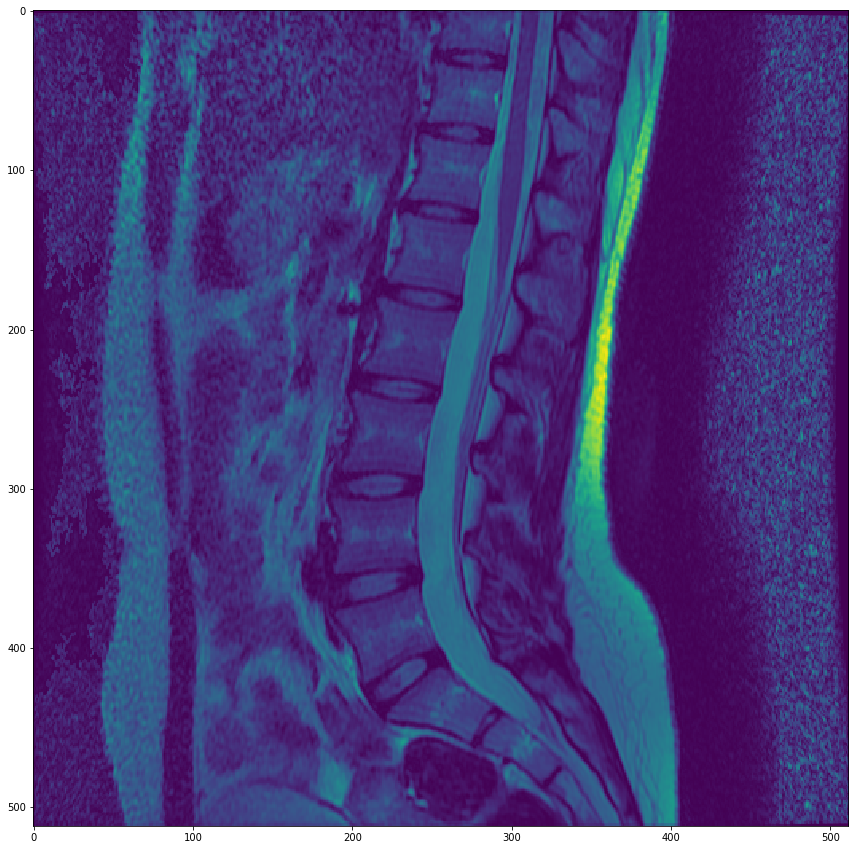

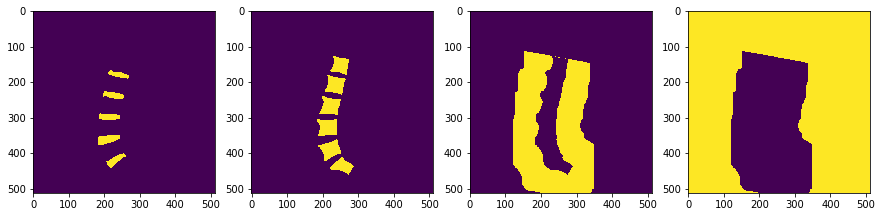

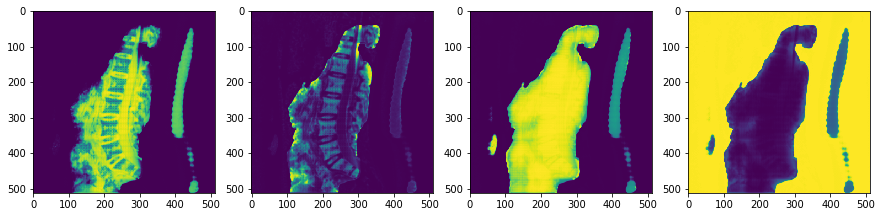

In [17]:
import math

def inference(best_model_weights):
    model = UNet(in_channels=C, out_channels=O)
    model.to(device) 
    model.load_state_dict(best_model_weights)
    
    model.eval()
    
    x_test, y_test = next(iter(spine_loader['test']))
    x_test, y_test = x_test.float(), y_test.float()
    x_test, y_test = x_test.to(device), y_test.to(device)
    
    y_pred = model(x_test)
    y_pred = y_pred.data.cpu().numpy()
    
    print(y_pred.shape)
    
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
    axs.imshow(x_test.data.cpu().numpy()[0, 0])

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
    axs[0].imshow(y_test.data.cpu().numpy()[0, 0])
    axs[1].imshow(y_test.data.cpu().numpy()[0, 1])
    axs[2].imshow(y_test.data.cpu().numpy()[0, 2])
    axs[3].imshow(y_test.data.cpu().numpy()[0, 3])

    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
    axs[0].imshow(y_pred[0, 0])
    axs[1].imshow(y_pred[0, 1])
    axs[2].imshow(y_pred[0, 2])
    axs[3].imshow(y_pred[0, 3])
    
inference(best_model_weights)